In [ ]:
# create connectivity matrix - see "create_condition_matrices.py" for details

In [1]:
# Basic data manipulation and visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os

# Network Libraries
import networkx as nx
import community

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set up paths
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f'{curr_dir}/results'

def load_condition_matrices(results_dir, condition, n_rois=200):
    """
    Load and average connectivity matrices for a specific condition
    """
    matrix_dir = f'{results_dir}/connectivity_matrices_{n_rois}_standard_{condition.lower()}'
    matrix_files = glob.glob(f'{matrix_dir}/*_connectivity_matrix_{condition.lower()}.npy')
    
    if not matrix_files:
        raise FileNotFoundError(f"No {condition} connectivity matrices found in {matrix_dir}")
    
    print(f"Found {len(matrix_files)} {condition} connectivity matrices")
    
    matrices = [np.load(file) for file in matrix_files]
    matrix = np.mean(matrices, axis=0)
    
    return matrix

# Load data for both conditions
object_matrix = load_condition_matrices(results_dir, 'object')
scramble_matrix = load_condition_matrices(results_dir, 'scramble')

Found 18 object connectivity matrices
Found 18 scramble connectivity matrices


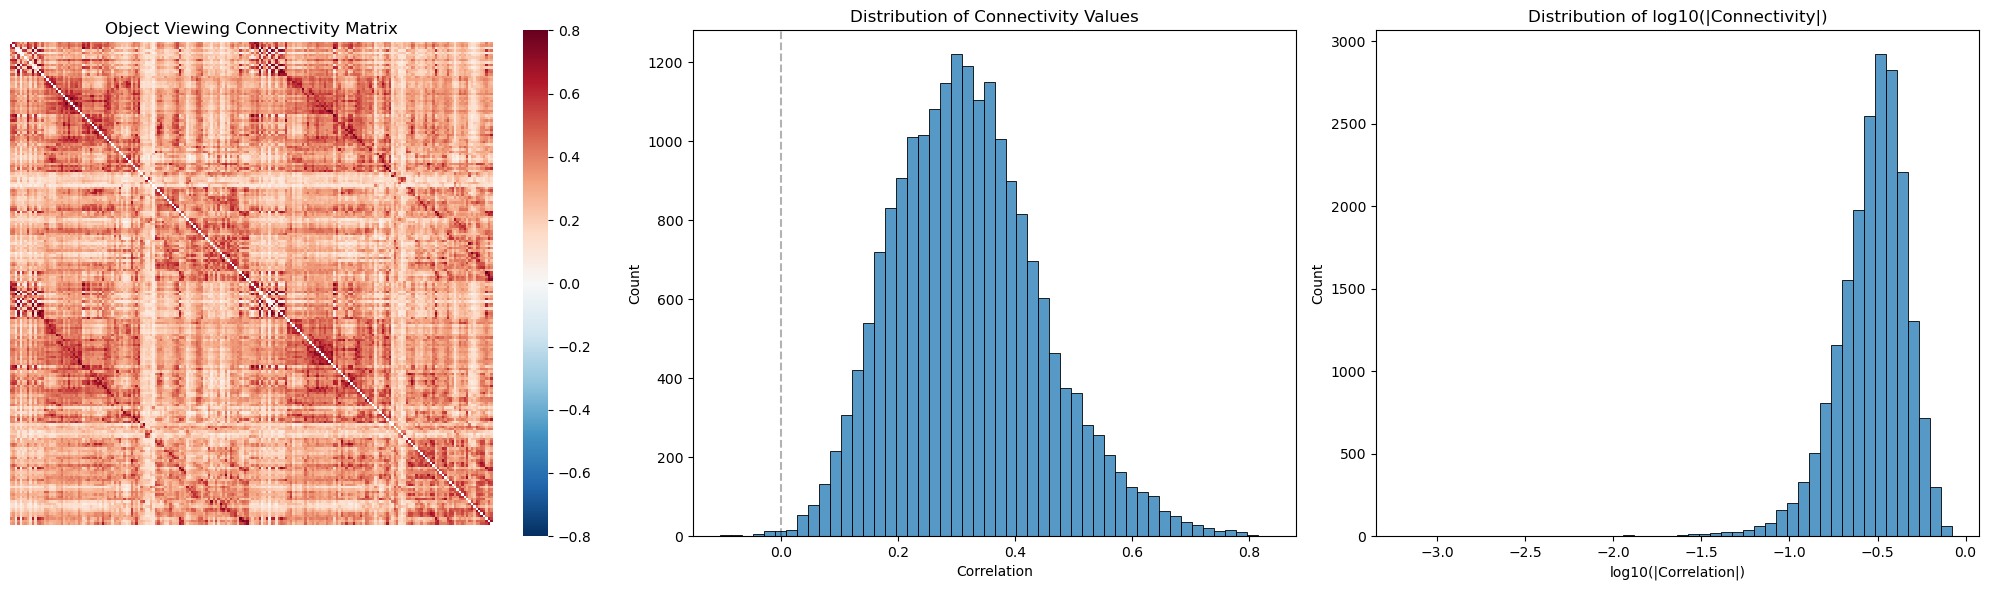


Object Viewing Connectivity Statistics:
Mean correlation: 0.320
Standard deviation: 0.128
Min correlation: -0.104
Max correlation: 0.833


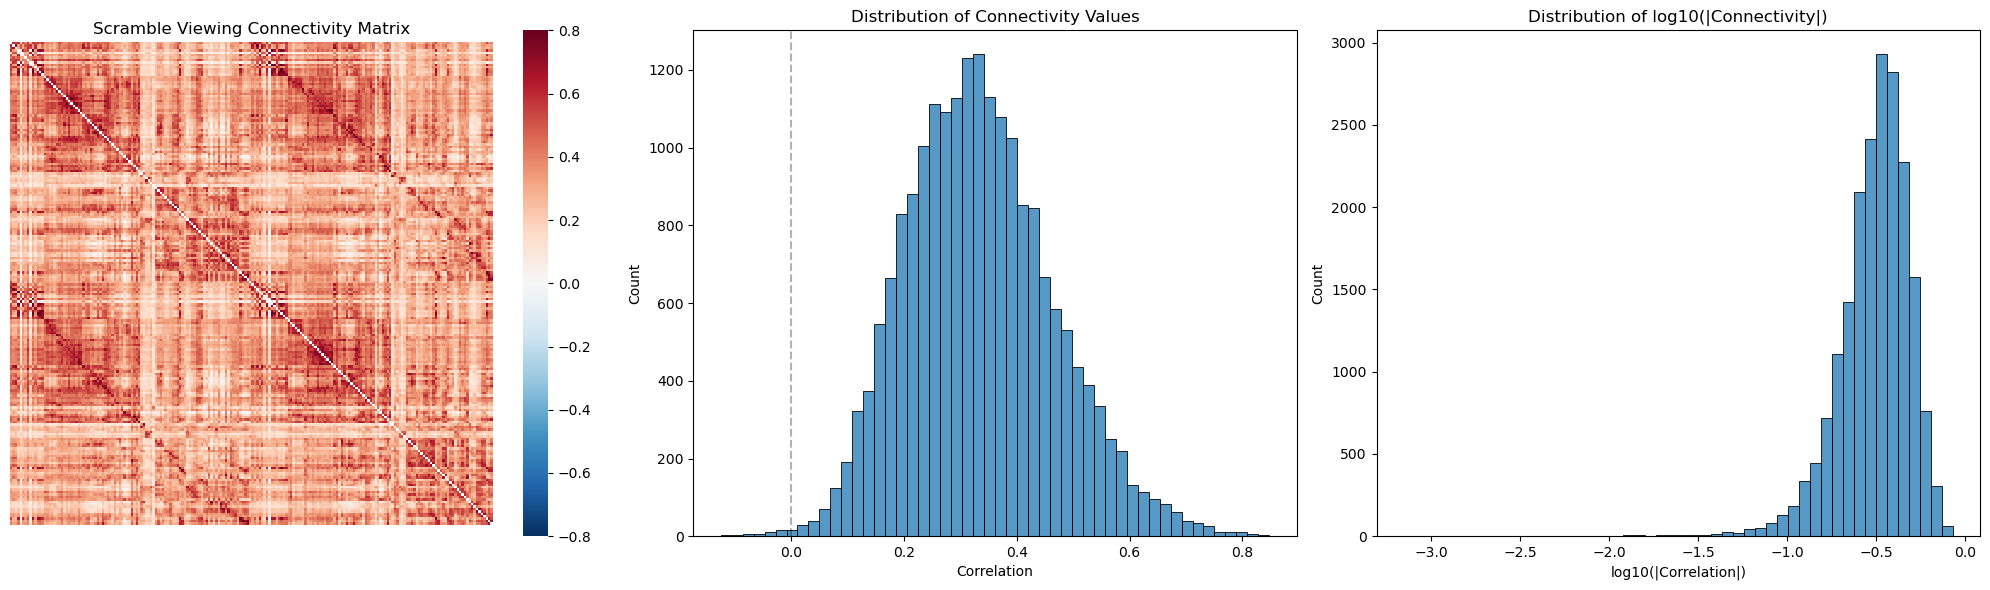


Scramble Viewing Connectivity Statistics:
Mean correlation: 0.334
Standard deviation: 0.131
Min correlation: -0.125
Max correlation: 0.848


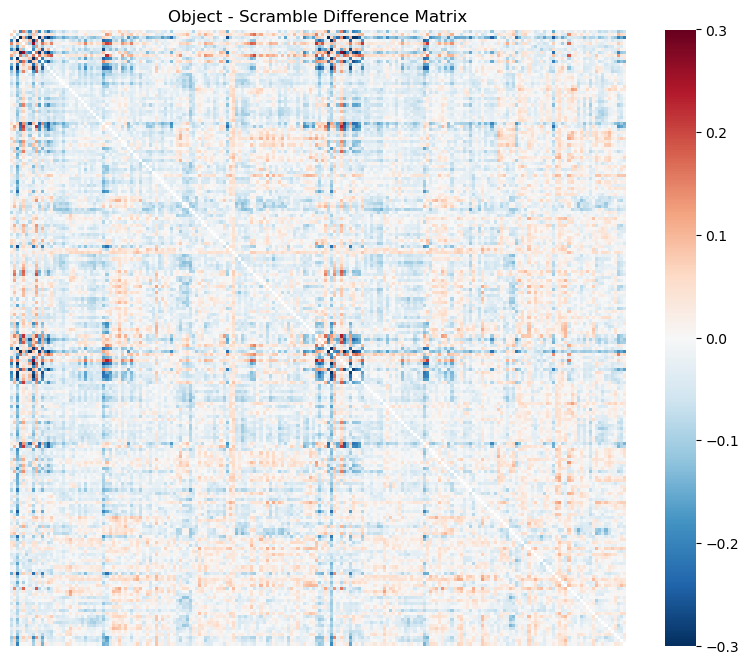

In [2]:
# Create basic visualization of average connectivity matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# Setup
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
n_rois = 200

def load_and_average_matrices(condition):
    """Load all subject matrices for a condition and compute average"""
    matrix_dir = f'{results_dir}/connectivity_matrices_{n_rois}_standard_{condition.lower()}'
    matrices = []
    
    for matrix_file in glob.glob(f'{matrix_dir}/*_connectivity_matrix_{condition.lower()}.npy'):
        matrix = np.load(matrix_file)
        matrices.append(matrix)
    
    return np.mean(matrices, axis=0)

# Load average matrices for both conditions
object_matrix = load_and_average_matrices('object')
scramble_matrix = load_and_average_matrices('scramble')

# Visualization function
def plot_connectivity_analysis(matrix, title):
    # Create figure with 3 subplots
    fig = plt.figure(figsize=(20, 6))
    
    # 1. Connectivity Matrix Heatmap
    plt.subplot(131)
    matrix_plot = matrix.copy()
    np.fill_diagonal(matrix_plot, np.nan)
    
    sns.heatmap(matrix_plot, 
                cmap='RdBu_r',
                center=0,
                vmin=-0.8,
                vmax=0.8,
                square=True,
                xticklabels=False,
                yticklabels=False)
    plt.title(f'{title} Connectivity Matrix')
    
    # 2. Raw Distribution
    plt.subplot(132)
    mask = np.triu(np.ones(matrix.shape)).astype(bool)
    flat_matrix = matrix[~mask]
    
    sns.histplot(flat_matrix, bins=50)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.title('Distribution of Connectivity Values')
    plt.xlabel('Correlation')
    plt.ylabel('Count')
    
    # 3. Log Distribution
    plt.subplot(133)
    log_matrix = np.log10(np.abs(flat_matrix[flat_matrix != 0]))
    sns.histplot(log_matrix, bins=50)
    plt.title('Distribution of log10(|Connectivity|)')
    plt.xlabel('log10(|Correlation|)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{title} Connectivity Statistics:")
    print(f"Mean correlation: {np.mean(flat_matrix):.3f}")
    print(f"Standard deviation: {np.std(flat_matrix):.3f}")
    print(f"Min correlation: {np.min(flat_matrix):.3f}")
    print(f"Max correlation: {np.max(flat_matrix):.3f}")

# Plot both conditions
plot_connectivity_analysis(object_matrix, "Object Viewing")
plot_connectivity_analysis(scramble_matrix, "Scramble Viewing")

# Plot difference matrix (Object - Scramble)
diff_matrix = object_matrix - scramble_matrix
plt.figure(figsize=(10, 8))
np.fill_diagonal(diff_matrix, np.nan)
sns.heatmap(diff_matrix, 
            cmap='RdBu_r',
            center=0,
            vmin=-0.3,
            vmax=0.3,
            square=True,
            xticklabels=False,
            yticklabels=False)
plt.title('Object - Scramble Difference Matrix')
plt.show()

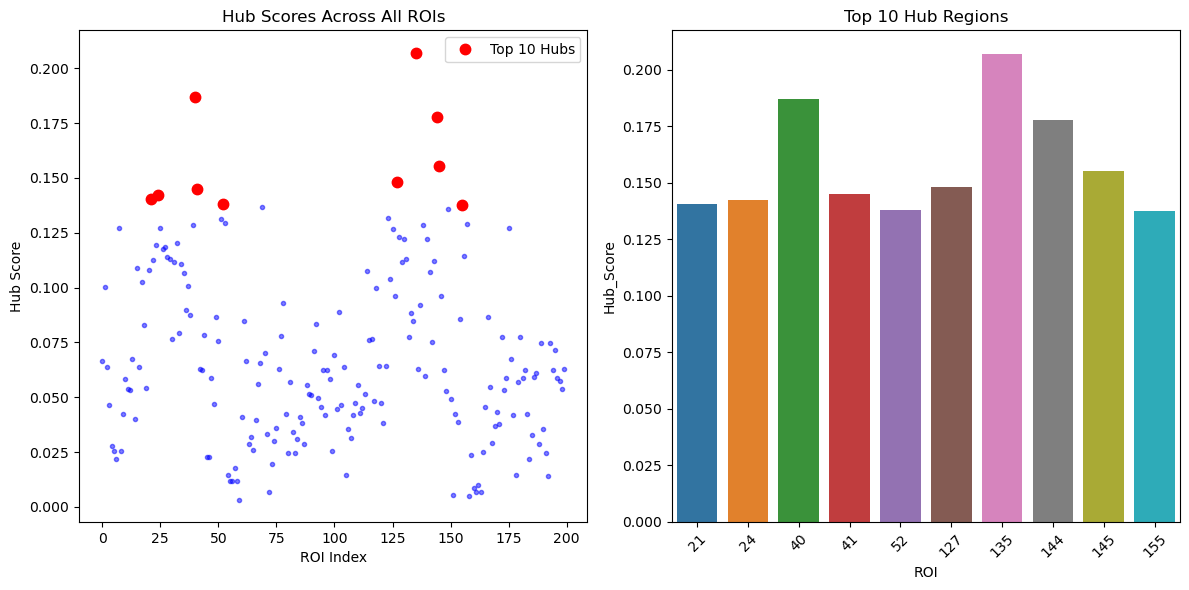


Top Hub Regions During Object Viewing:

ROI 135:
  Hub Score: 0.207
  Degree Centrality: 0.387
  Betweenness Centrality: 0.043
  Eigenvector Centrality: 0.191

ROI 40:
  Hub Score: 0.187
  Degree Centrality: 0.352
  Betweenness Centrality: 0.025
  Eigenvector Centrality: 0.185

ROI 144:
  Hub Score: 0.178
  Degree Centrality: 0.332
  Betweenness Centrality: 0.022
  Eigenvector Centrality: 0.179

ROI 145:
  Hub Score: 0.155
  Degree Centrality: 0.296
  Betweenness Centrality: 0.021
  Eigenvector Centrality: 0.148

ROI 127:
  Hub Score: 0.148
  Degree Centrality: 0.276
  Betweenness Centrality: 0.008
  Eigenvector Centrality: 0.160

ROI 41:
  Hub Score: 0.145
  Degree Centrality: 0.271
  Betweenness Centrality: 0.019
  Eigenvector Centrality: 0.145

ROI 24:
  Hub Score: 0.142
  Degree Centrality: 0.271
  Betweenness Centrality: 0.009
  Eigenvector Centrality: 0.146

ROI 21:
  Hub Score: 0.141
  Degree Centrality: 0.266
  Betweenness Centrality: 0.017
  Eigenvector Centrality: 0.139

ROI

In [6]:
# Function to identify and analyze hubs
def analyze_object_hubs(object_matrix, scramble_matrix):
    """Analyze hub regions during object viewing"""
    
    # Create network from object viewing data
    # Threshold the matrix to keep only strong connections
    threshold = np.mean(object_matrix) + np.std(object_matrix)
    object_matrix_thresh = object_matrix.copy()
    object_matrix_thresh[object_matrix_thresh < threshold] = 0
    
    # Create network
    G_object = nx.from_numpy_array(object_matrix_thresh)
    
    # Calculate multiple centrality metrics
    degree_cent = nx.degree_centrality(G_object)
    betweenness_cent = nx.betweenness_centrality(G_object)
    eigenvector_cent = nx.eigenvector_centrality_numpy(G_object)
    
    # Convert to arrays for easier handling
    metrics = pd.DataFrame({
        'ROI': range(len(degree_cent)),
        'Degree': list(degree_cent.values()),
        'Betweenness': list(betweenness_cent.values()),
        'Eigenvector': list(eigenvector_cent.values())
    })
    
    # Find top hubs across metrics
    metrics['Hub_Score'] = (metrics['Degree'] + 
                          metrics['Betweenness'] + 
                          metrics['Eigenvector']) / 3
    
    # Sort by hub score
    top_hubs = metrics.nlargest(10, 'Hub_Score')
    
    return metrics, top_hubs

# Run analysis
metrics_df, top_hubs = analyze_object_hubs(object_matrix, scramble_matrix)

# Visualize top hubs
plt.figure(figsize=(12, 6))

# Plot hub scores for all ROIs
plt.subplot(121)
plt.plot(metrics_df['Hub_Score'], 'b.', alpha=0.5)
plt.title('Hub Scores Across All ROIs')
plt.xlabel('ROI Index')
plt.ylabel('Hub Score')

# Highlight top 10 hubs
plt.plot(top_hubs['ROI'], top_hubs['Hub_Score'], 'r.', markersize=15, 
         label='Top 10 Hubs')
plt.legend()

# Bar plot of top hubs
plt.subplot(122)
sns.barplot(data=top_hubs, x='ROI', y='Hub_Score')
plt.title('Top 10 Hub Regions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print detailed results for top hubs
print("\nTop Hub Regions During Object Viewing:")
print("=====================================")
for _, hub in top_hubs.iterrows():
    print(f"\nROI {int(hub['ROI'])}:")
    print(f"  Hub Score: {hub['Hub_Score']:.3f}")
    print(f"  Degree Centrality: {hub['Degree']:.3f}")
    print(f"  Betweenness Centrality: {hub['Betweenness']:.3f}")
    print(f"  Eigenvector Centrality: {hub['Eigenvector']:.3f}")

<Figure size 1000x1000 with 0 Axes>

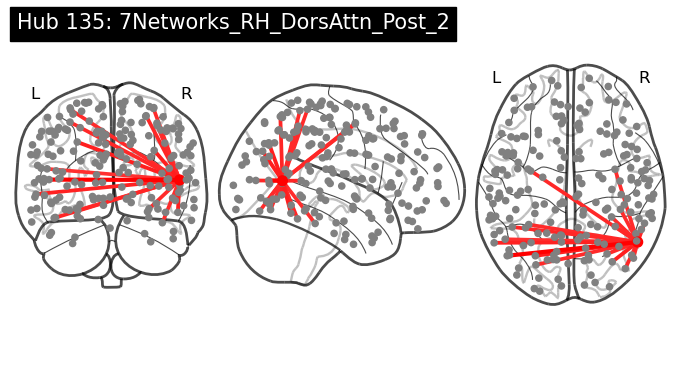


Hub 135 (7Networks_RH_DorsAttn_Post_2) strongest connections:
- 7Networks_LH_Vis_2 (r = 0.602)
- 7Networks_LH_Vis_8 (r = 0.721)
- 7Networks_LH_SomMot_11 (r = 0.598)
- 7Networks_LH_DorsAttn_Post_1 (r = 0.609)
- 7Networks_LH_DorsAttn_Post_2 (r = 0.622)


<Figure size 1000x1000 with 0 Axes>

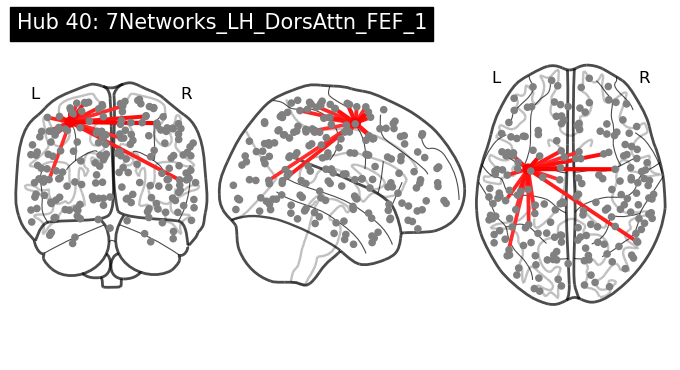


Hub 40 (7Networks_LH_DorsAttn_FEF_1) strongest connections:
- 7Networks_LH_Vis_8 (r = 0.563)
- 7Networks_LH_SomMot_7 (r = 0.605)
- 7Networks_LH_SomMot_8 (r = 0.564)
- 7Networks_LH_SomMot_9 (r = 0.594)
- 7Networks_LH_SomMot_10 (r = 0.636)


<Figure size 1000x1000 with 0 Axes>

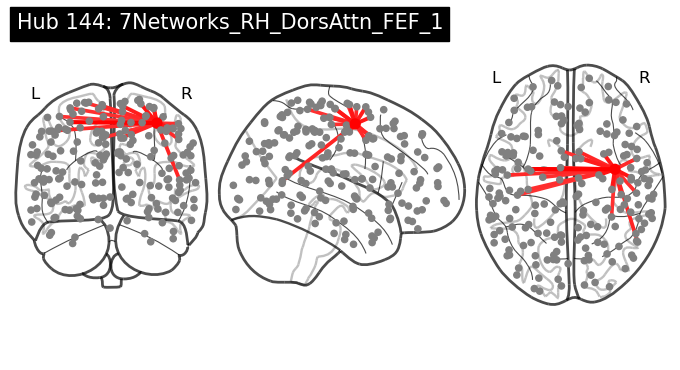


Hub 144 (7Networks_RH_DorsAttn_FEF_1) strongest connections:
- 7Networks_LH_SomMot_7 (r = 0.580)
- 7Networks_LH_SomMot_10 (r = 0.554)
- 7Networks_LH_SomMot_12 (r = 0.563)
- 7Networks_LH_SomMot_14 (r = 0.560)
- 7Networks_LH_DorsAttn_FEF_1 (r = 0.689)


<Figure size 1000x1000 with 0 Axes>

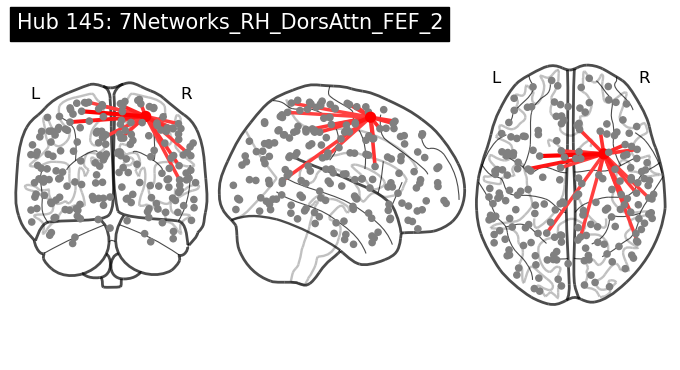


Hub 145 (7Networks_RH_DorsAttn_FEF_2) strongest connections:
- 7Networks_LH_DorsAttn_Post_10 (r = 0.527)
- 7Networks_LH_DorsAttn_FEF_1 (r = 0.648)
- 7Networks_LH_DorsAttn_FEF_2 (r = 0.710)
- 7Networks_LH_SalVentAttn_Med_1 (r = 0.547)
- 7Networks_LH_SalVentAttn_Med_3 (r = 0.540)


In [9]:
# Import nilearn for brain visualization
from nilearn import datasets, plotting
import numpy as np

def visualize_hub_networks(object_matrix, top_hub_indices):
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200)
    coords = plotting.find_parcellation_cut_coords(atlas.maps)
    labels = [label.decode('utf-8') for label in atlas.labels]
    
    # Create separate plots for each hub
    for hub_idx in top_hub_indices:
        # Get connections for this hub
        hub_connections = object_matrix[hub_idx]
        
        # Threshold to show only strong connections
        threshold = np.percentile(np.abs(hub_connections), 90)  # Top 10% of connections
        hub_connections[np.abs(hub_connections) < threshold] = 0
        
        # Create connection matrix for this hub
        hub_matrix = np.zeros_like(object_matrix)
        hub_matrix[hub_idx, :] = hub_connections
        hub_matrix[:, hub_idx] = hub_connections
        
        # Plot
        plt.figure(figsize=(10, 10))
        plotting.plot_connectome(hub_matrix, coords,
                               node_color=['red' if i == hub_idx else 'gray' for i in range(len(coords))],
                               node_size=[50 if i == hub_idx else 20 for i in range(len(coords))],
                               edge_threshold='90%',
                               display_mode='ortho',
                               title=f'Hub {hub_idx}: {labels[hub_idx]}')
        plt.show()
        
        # Print connection information
        print(f"\nHub {hub_idx} ({labels[hub_idx]}) strongest connections:")
        strong_connections = np.where(hub_connections > threshold)[0]
        for conn_idx in strong_connections[:5]:  # Show top 5 connections
            print(f"- {labels[conn_idx]} (r = {hub_connections[conn_idx]:.3f})")

# Our top hubs from previous analysis
top_hub_indices = [135, 40, 144, 145]  # Using top 4 hubs

# Create visualizations
visualize_hub_networks(object_matrix, top_hub_indices)


<Figure size 1000x1000 with 0 Axes>

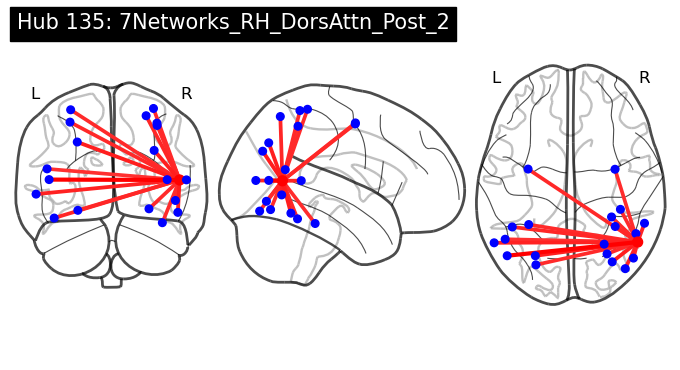


Hub 135 (7Networks_RH_DorsAttn_Post_2) strongest connections:
- 7Networks_LH_Vis_2 (r = 0.602)
- 7Networks_LH_Vis_8 (r = 0.721)
- 7Networks_LH_SomMot_11 (r = 0.598)
- 7Networks_LH_DorsAttn_Post_1 (r = 0.609)
- 7Networks_LH_DorsAttn_Post_2 (r = 0.622)


<Figure size 1000x1000 with 0 Axes>

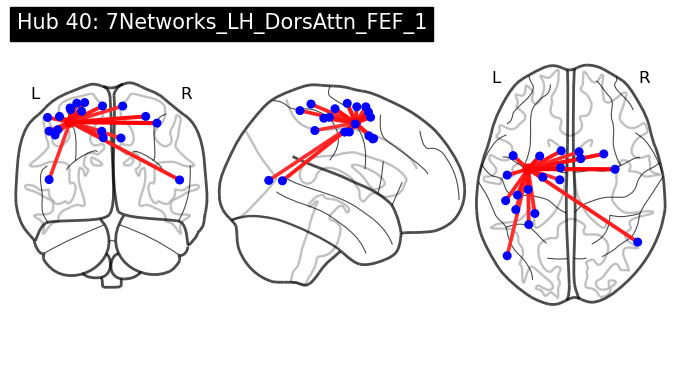


Hub 40 (7Networks_LH_DorsAttn_FEF_1) strongest connections:
- 7Networks_LH_Vis_8 (r = 0.563)
- 7Networks_LH_SomMot_7 (r = 0.605)
- 7Networks_LH_SomMot_8 (r = 0.564)
- 7Networks_LH_SomMot_9 (r = 0.594)
- 7Networks_LH_SomMot_10 (r = 0.636)


<Figure size 1000x1000 with 0 Axes>

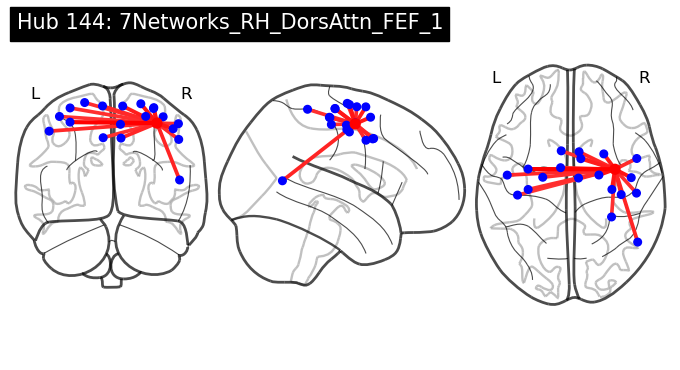


Hub 144 (7Networks_RH_DorsAttn_FEF_1) strongest connections:
- 7Networks_LH_SomMot_7 (r = 0.580)
- 7Networks_LH_SomMot_10 (r = 0.554)
- 7Networks_LH_SomMot_12 (r = 0.563)
- 7Networks_LH_SomMot_14 (r = 0.560)
- 7Networks_LH_DorsAttn_FEF_1 (r = 0.689)


<Figure size 1000x1000 with 0 Axes>

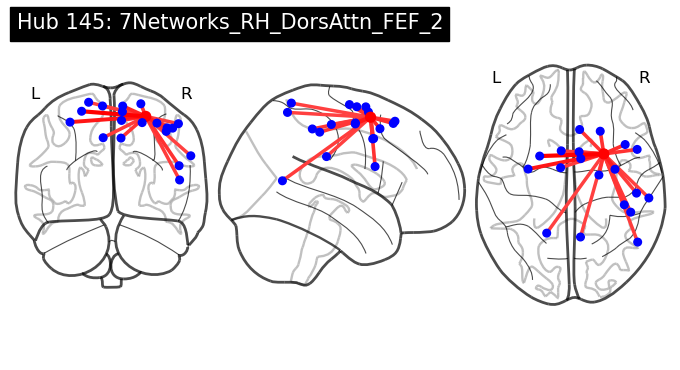


Hub 145 (7Networks_RH_DorsAttn_FEF_2) strongest connections:
- 7Networks_LH_DorsAttn_Post_10 (r = 0.527)
- 7Networks_LH_DorsAttn_FEF_1 (r = 0.648)
- 7Networks_LH_DorsAttn_FEF_2 (r = 0.710)
- 7Networks_LH_SalVentAttn_Med_1 (r = 0.547)
- 7Networks_LH_SalVentAttn_Med_3 (r = 0.540)


In [10]:
from nilearn import datasets, plotting
import numpy as np

def visualize_hub_networks(object_matrix, top_hub_indices):
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200)
    coords = plotting.find_parcellation_cut_coords(atlas.maps)
    labels = [label.decode('utf-8') for label in atlas.labels]
    
    # Create separate plots for each hub
    for hub_idx in top_hub_indices:
        # Get connections for this hub
        hub_connections = object_matrix[hub_idx]
        
        # Threshold to show only strong connections
        threshold = np.percentile(np.abs(hub_connections), 90)  # Top 10% of connections
        strong_connections = np.where(hub_connections > threshold)[0]
        
        # Create connection matrix for just the strong connections
        hub_matrix = np.zeros_like(object_matrix)
        hub_matrix[hub_idx, strong_connections] = hub_connections[strong_connections]
        hub_matrix[strong_connections, hub_idx] = hub_connections[strong_connections]
        
        # Create node colors and sizes (only for connected nodes)
        node_colors = []
        node_sizes = []
        for i in range(len(coords)):
            if i == hub_idx:
                node_colors.append('red')
                node_sizes.append(50)
            elif i in strong_connections:
                node_colors.append('blue')
                node_sizes.append(30)
            else:
                node_colors.append('gray')
                node_sizes.append(0)  # Hide unconnected nodes
        
        # Plot
        plt.figure(figsize=(10, 10))
        plotting.plot_connectome(hub_matrix, coords,
                               node_color=node_colors,
                               node_size=node_sizes,
                               edge_threshold='90%',
                               display_mode='ortho',
                               title=f'Hub {hub_idx}: {labels[hub_idx]}')
        plt.show()
        
        # Print connection information
        print(f"\nHub {hub_idx} ({labels[hub_idx]}) strongest connections:")
        for conn_idx in strong_connections[:5]:  # Show top 5 connections
            print(f"- {labels[conn_idx]} (r = {hub_connections[conn_idx]:.3f})")

# Our top hubs from previous analysis
top_hub_indices = [135, 40, 144, 145]  # Using top 4 hubs

# Create visualizations
visualize_hub_networks(object_matrix, top_hub_indices)

In [16]:
# plot hubs by hemisphere
from nilearn import datasets, plotting
import numpy as np
import matplotlib.pyplot as plt

def visualize_hemispheric_hubs(top_hubs_df):
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200)
    coords = plotting.find_parcellation_cut_coords(atlas.maps)
    labels = [label.decode('utf-8') for label in atlas.labels]
    
    # Separate hubs by hemisphere
    left_hubs = [int(idx) for idx in top_hubs_df['ROI'] if 'LH' in labels[int(idx)]]
    right_hubs = [int(idx) for idx in top_hubs_df['ROI'] if 'RH' in labels[int(idx)]]
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    views = ['x', 'y', 'z']
    
    for i, view in enumerate(views):
        # Create display
        display = plotting.plot_glass_brain(None,
                                          display_mode=view,
                                          figure=fig,
                                          axes=axes[i],
                                          alpha=0.1)
        
        # Plot left hemisphere hubs
        if left_hubs:
            display.add_markers(coords[left_hubs],
                              c='red',  # Changed from color to c
                              marker_size=100)
        
        # Plot right hemisphere hubs
        if right_hubs:
            display.add_markers(coords[right_hubs],
                              c='blue',  # Changed from color to c
                              marker_size=100)
    
    plt.suptitle('Top Hubs by Hemisphere (Red: Left, Blue: Right)')
    plt.tight_layout()
    plt.show()
    
    # Print hub information by hemisphere
    print("\nLeft Hemisphere Hubs:")
    for hub in left_hubs:
        print(f"ROI {hub}: {labels[hub]} (Hub Score: {top_hubs_df[top_hubs_df['ROI']==hub]['Hub_Score'].values[0]:.3f})")
    
    print("\nRight Hemisphere Hubs:")
    for hub in right_hubs:
        print(f"ROI {hub}: {labels[hub]} (Hub Score: {top_hubs_df[top_hubs_df['ROI']==hub]['Hub_Score'].values[0]:.3f})")

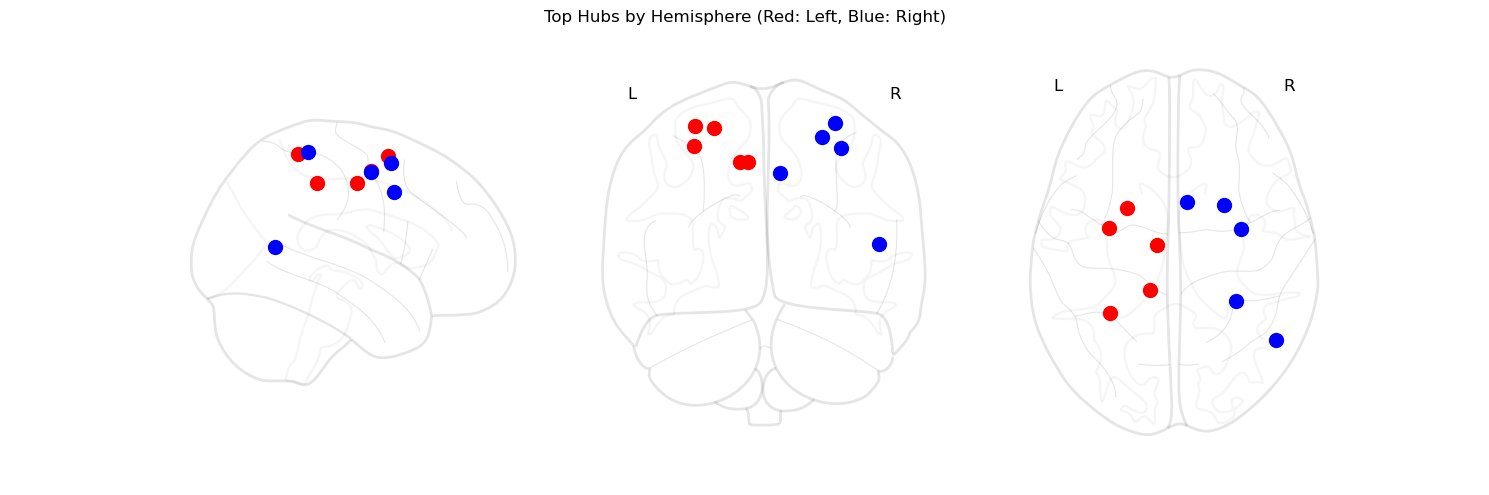


Left Hemisphere Hubs:
ROI 40: 7Networks_LH_DorsAttn_FEF_1 (Hub Score: 0.187)
ROI 41: 7Networks_LH_DorsAttn_FEF_2 (Hub Score: 0.145)
ROI 24: 7Networks_LH_SomMot_11 (Hub Score: 0.142)
ROI 21: 7Networks_LH_SomMot_8 (Hub Score: 0.141)
ROI 52: 7Networks_LH_SalVentAttn_Med_2 (Hub Score: 0.138)

Right Hemisphere Hubs:
ROI 135: 7Networks_RH_DorsAttn_Post_2 (Hub Score: 0.207)
ROI 144: 7Networks_RH_DorsAttn_FEF_1 (Hub Score: 0.178)
ROI 145: 7Networks_RH_DorsAttn_FEF_2 (Hub Score: 0.155)
ROI 127: 7Networks_RH_SomMot_13 (Hub Score: 0.148)
ROI 155: 7Networks_RH_SalVentAttn_Med_1 (Hub Score: 0.138)


In [18]:
import pandas as pd
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import numpy as np

# Create DataFrame from the hub information
data = {
    'ROI': [135, 40, 144, 145, 127, 41, 24, 21, 52, 155],
    'Hub_Score': [0.207, 0.187, 0.178, 0.155, 0.148, 0.145, 0.142, 0.141, 0.138, 0.138],
    'Degree_Centrality': [0.387, 0.352, 0.332, 0.296, 0.276, 0.271, 0.271, 0.266, 0.281, 0.261],
    'Betweenness_Centrality': [0.043, 0.025, 0.022, 0.021, 0.008, 0.019, 0.009, 0.017, 0.048, 0.022],
    'Eigenvector_Centrality': [0.191, 0.185, 0.179, 0.148, 0.160, 0.145, 0.146, 0.139, 0.085, 0.129]
}

top_hubs = pd.DataFrame(data)

def visualize_hemispheric_hubs(top_hubs_df):
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200)
    coords = plotting.find_parcellation_cut_coords(atlas.maps)
    labels = [label.decode('utf-8') for label in atlas.labels]
    
    # Separate hubs by hemisphere
    left_hubs = [int(idx) for idx in top_hubs_df['ROI'] if 'LH' in labels[int(idx)]]
    right_hubs = [int(idx) for idx in top_hubs_df['ROI'] if 'RH' in labels[int(idx)]]
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    views = ['x', 'y', 'z']
    
    for i, view in enumerate(views):
        # Create display
        display = plotting.plot_glass_brain(None,
                                          display_mode=view,
                                          figure=fig,
                                          axes=axes[i],
                                          alpha=0.1)
        
        # Plot left hemisphere hubs
        if left_hubs:
            display.add_markers(coords[left_hubs],
                              marker_color='red',  # Changed from c to marker_color
                              marker_size=100)
        
        # Plot right hemisphere hubs
        if right_hubs:
            display.add_markers(coords[right_hubs],
                              marker_color='blue',  # Changed from c to marker_color
                              marker_size=100)
    
    plt.suptitle('Top Hubs by Hemisphere (Red: Left, Blue: Right)')
    plt.tight_layout()
    plt.show()
    
    # Print hub information by hemisphere
    print("\nLeft Hemisphere Hubs:")
    for hub in left_hubs:
        print(f"ROI {hub}: {labels[hub]} (Hub Score: {top_hubs_df[top_hubs_df['ROI']==hub]['Hub_Score'].values[0]:.3f})")
    
    print("\nRight Hemisphere Hubs:")
    for hub in right_hubs:
        print(f"ROI {hub}: {labels[hub]} (Hub Score: {top_hubs_df[top_hubs_df['ROI']==hub]['Hub_Score'].values[0]:.3f})")

# Run the visualization
visualize_hemispheric_hubs(top_hubs)

In [19]:
# Load Schaefer atlas labels
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200)
labels = [label.decode('utf-8') for label in atlas.labels]

# Get anatomical locations for our top hubs
top_hub_indices = [135, 40, 144, 145, 127, 41, 24, 21, 52, 155]
for hub in top_hub_indices:
    print(f"ROI {hub}: {labels[hub]}")

ROI 135: 7Networks_RH_DorsAttn_Post_2
ROI 40: 7Networks_LH_DorsAttn_FEF_1
ROI 144: 7Networks_RH_DorsAttn_FEF_1
ROI 145: 7Networks_RH_DorsAttn_FEF_2
ROI 127: 7Networks_RH_SomMot_13
ROI 41: 7Networks_LH_DorsAttn_FEF_2
ROI 24: 7Networks_LH_SomMot_11
ROI 21: 7Networks_LH_SomMot_8
ROI 52: 7Networks_LH_SalVentAttn_Med_2
ROI 155: 7Networks_RH_SalVentAttn_Med_1


In [5]:
## FDR correction for SCHAEFER MATRIX 200

In [4]:
# Create network from FDR-corrected matrix

In [27]:
def create_network_variants(matrix):
    """Create networks with different thresholding approaches"""
    variants = {}
    
    # Helper function to process matrix and create graph
    def create_graph(mat):
        G = nx.from_numpy_array(mat)
        G.remove_edges_from(nx.selfloop_edges(G))
        # Convert weights to distances for path calculations (inverse of correlation)
        for u, v, d in G.edges(data=True):
            d['distance'] = 1.0 / (d['weight'] + 1e-6)  # Add small constant to avoid division by zero
        return G
    
    # 1. Dense network (all connections)
    variants['dense'] = create_graph(matrix)
    
    # 2. Threshold at mean + std
    threshold = np.mean(matrix) + np.std(matrix)
    matrix_thresh = matrix.copy()
    matrix_thresh[matrix_thresh < threshold] = 0
    variants['threshold'] = create_graph(matrix_thresh)
    
    # 3. Density-based thresholds
    for density in [0.1, 0.25]:
        k = int(density * (matrix.shape[0] * (matrix.shape[0] - 1)) / 2)
        matrix_density = matrix.copy()
        flat_matrix = np.triu(matrix_density, k=1).flatten()
        flat_matrix = flat_matrix[flat_matrix != 0]
        threshold = np.sort(flat_matrix)[-k]
        matrix_density[matrix_density < threshold] = 0
        variants[f'density_{density}'] = create_graph(matrix_density)
    
    return variants

# Create network variants for both conditions
object_networks = create_network_variants(object_matrix)
scramble_networks = create_network_variants(scramble_matrix)

# Print basic info about created networks
for name, G in object_networks.items():
    print(f"\nObject {name} network:")
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges: {G.number_of_edges()}")


Object dense network:
Nodes: 200
Edges: 19900

Object threshold network:
Nodes: 200
Edges: 2696

Object density_0.1 network:
Nodes: 200
Edges: 2030

Object density_0.25 network:
Nodes: 200
Edges: 5106


Top Hubs - Object Viewing:
       degree  eigenvector  betweenness  closeness  composite_score
135  1.000000     1.000000     1.000000   1.000000         1.000000
40   0.886467     0.956569     0.318795   0.969363         0.782798
144  0.844352     0.926614     0.342585   0.947302         0.765213
52   0.703317     0.417214     0.731959   0.940846         0.698334
69   0.667216     0.588248     0.528945   0.943352         0.681940
145  0.742760     0.760248     0.272006   0.932508         0.676881
175  0.661067     0.492695     0.602696   0.920015         0.669118
21   0.680793     0.720926     0.337827   0.922731         0.665569
155  0.670683     0.673440     0.411578   0.905182         0.665221
51   0.632285     0.618756     0.423473   0.914220         0.647183

Top Hubs - Scramble Viewing:
       degree  eigenvector  betweenness  closeness  composite_score
135  1.000000     1.000000     1.000000   1.000000         1.000000
40   0.831872     0.923049     0.473282   0.928291         

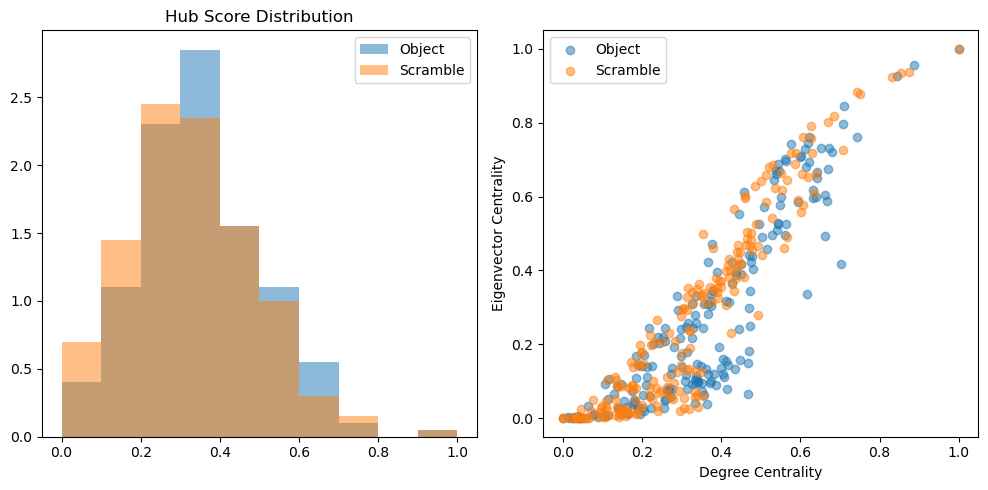

In [34]:
def analyze_network_hubs(G, metrics, n_hubs=10):
    """Analyze hub regions using multiple metrics"""
    
    # Get node strengths
    strengths = dict(G.degree(weight='weight'))
    
    # Get centrality metrics from previously computed metrics
    centrality_metrics = {
        'degree': strengths,
        'eigenvector': metrics.get('eigenvector_centrality', {}),
        'betweenness': metrics.get('betweenness_centrality', {}),
        'closeness': metrics.get('closeness_centrality', {})
    }
    
    # Create DataFrame with all metrics
    hub_df = pd.DataFrame(centrality_metrics)
    
    # Normalize each column
    for col in hub_df.columns:
        if not hub_df[col].empty:
            hub_df[col] = (hub_df[col] - hub_df[col].min()) / (hub_df[col].max() - hub_df[col].min())
    
    # Calculate composite score
    available_metrics = [col for col in hub_df.columns if not hub_df[col].empty]
    hub_df['composite_score'] = hub_df[available_metrics].mean(axis=1)
    
    # Get top hubs
    top_hubs = hub_df.nlargest(n_hubs, 'composite_score')
    
    return top_hubs, hub_df

# Analyze hubs for both conditions
object_hubs, object_hub_df = analyze_network_hubs(
    object_networks['threshold'],
    object_metrics['threshold']
)

scramble_hubs, scramble_hub_df = analyze_network_hubs(
    scramble_networks['threshold'],
    scramble_metrics['threshold']
)

# Print results
print("Top Hubs - Object Viewing:")
print(object_hubs)
print("\nTop Hubs - Scramble Viewing:")
print(scramble_hubs)

# Visualize hub metrics
plt.figure(figsize=(15, 5))

# Hub score distributions
plt.subplot(131)
plt.hist(object_hub_df['composite_score'], alpha=0.5, label='Object', density=True)
plt.hist(scramble_hub_df['composite_score'], alpha=0.5, label='Scramble', density=True)
plt.title('Hub Score Distribution')
plt.legend()

# Scatter plot of degree vs eigenvector centrality
plt.subplot(132)
plt.scatter(object_hub_df['degree'], object_hub_df['eigenvector'],
           alpha=0.5, label='Object')
plt.scatter(scramble_hub_df['degree'], scramble_hub_df['eigenvector'],
           alpha=0.5, label='Scramble')
plt.xlabel('Degree Centrality')
plt.ylabel('Eigenvector Centrality')
plt.legend()

plt.tight_layout()
plt.show()

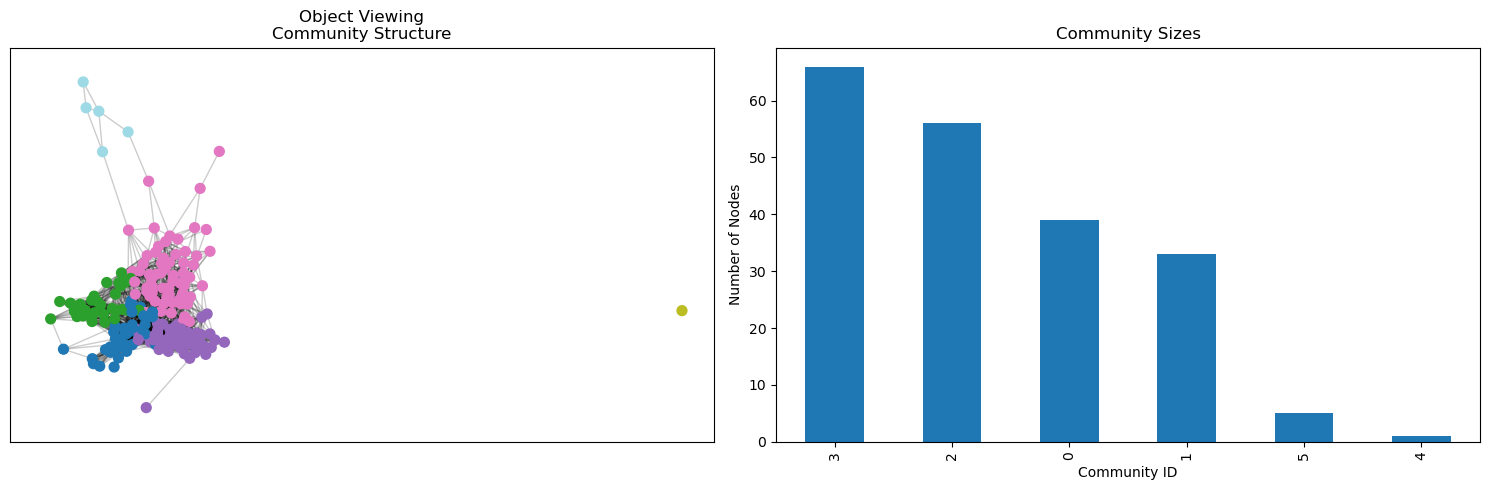

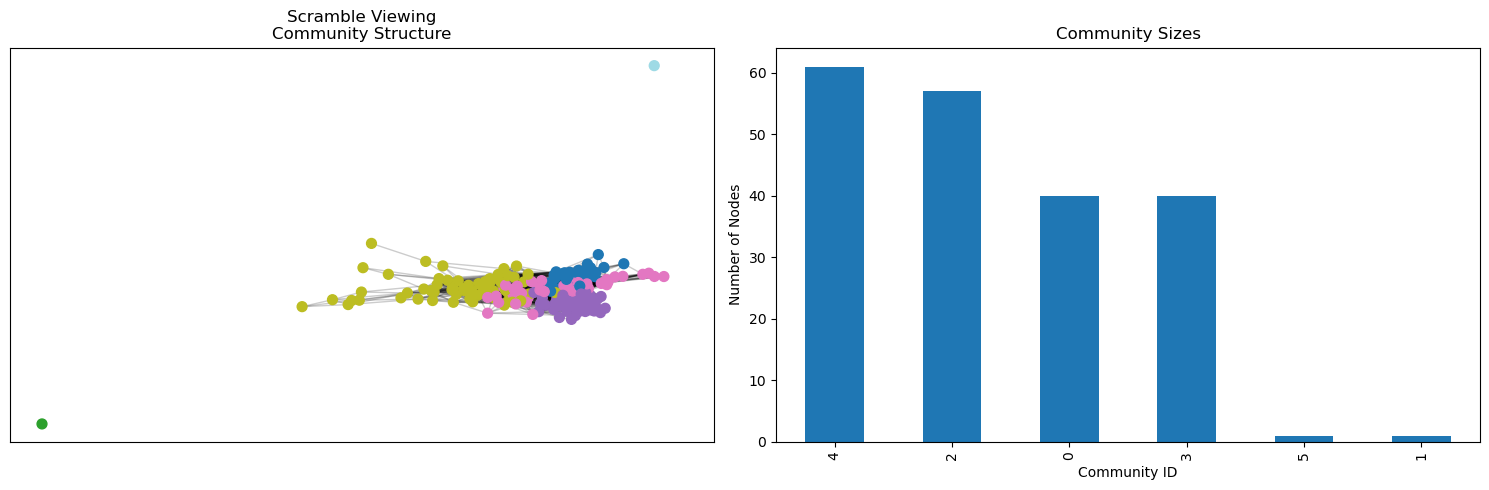

In [29]:
def analyze_communities(G, title):
    """Analyze and visualize community structure"""
    # Detect communities
    communities = community.best_partition(G)
    
    # Create color map
    node_colors = [communities[node] for node in G.nodes()]
    
    # Visualize
    plt.figure(figsize=(15, 5))
    
    # Community network
    plt.subplot(121)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          cmap=plt.cm.tab20, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    plt.title(f"{title}\nCommunity Structure")
    
    # Community size distribution
    plt.subplot(122)
    community_sizes = pd.Series(communities).value_counts()
    community_sizes.plot(kind='bar')
    plt.title("Community Sizes")
    plt.xlabel("Community ID")
    plt.ylabel("Number of Nodes")
    
    plt.tight_layout()
    plt.show()
    
    return communities

# Analyze communities for thresholded networks
object_communities = analyze_communities(object_networks['threshold'], 
                                      "Object Viewing")
scramble_communities = analyze_communities(scramble_networks['threshold'],
                                         "Scramble Viewing")

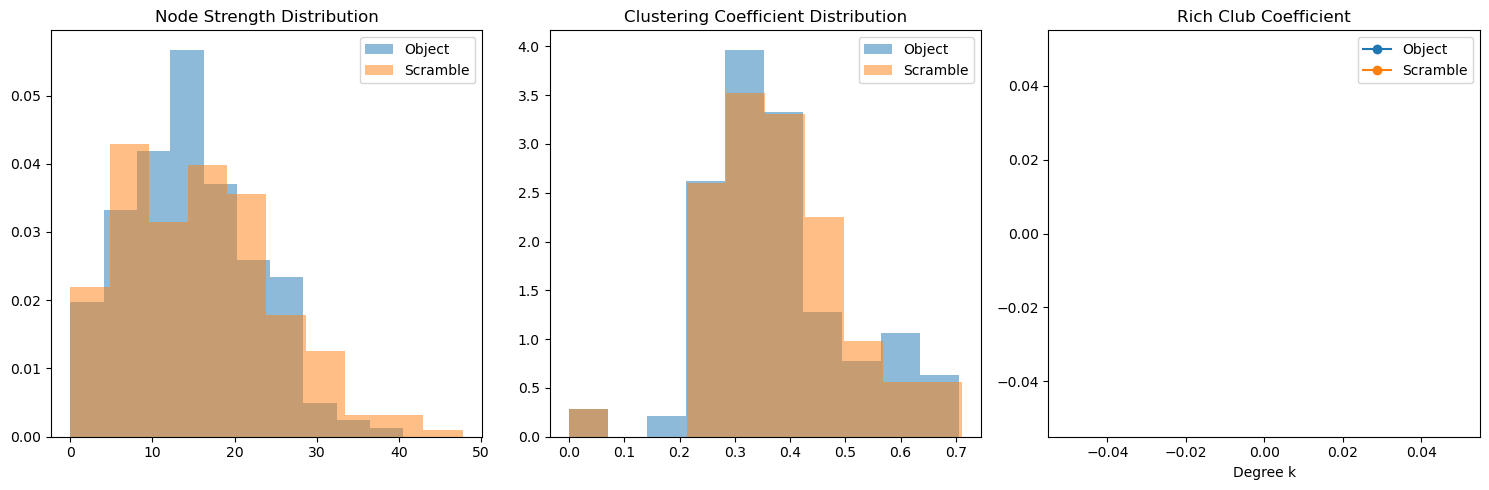

In [31]:
def compute_topological_properties(G):
    """Compute topological properties of the network"""
    # Get node strengths
    strengths = dict(G.degree(weight='weight'))
    
    # Get clustering coefficients
    clustering = nx.clustering(G, weight='weight')
    
    # Compute rich club coefficient for range of degrees
    rich_club = {}
    for k in range(5, 30, 5):
        try:
            rich_club[k] = nx.rich_club_coefficient(G, normalized=False, k=k)
        except:
            continue
    
    return strengths, clustering, rich_club

# Compute topological properties
object_topo = compute_topological_properties(object_networks['threshold'])
scramble_topo = compute_topological_properties(scramble_networks['threshold'])

# Visualize distributions
plt.figure(figsize=(15, 5))

# Node strengths
plt.subplot(131)
plt.hist(list(object_topo[0].values()), alpha=0.5, label='Object', density=True)
plt.hist(list(scramble_topo[0].values()), alpha=0.5, label='Scramble', density=True)
plt.title('Node Strength Distribution')
plt.legend()

# Clustering coefficients
plt.subplot(132)
plt.hist(list(object_topo[1].values()), alpha=0.5, label='Object', density=True)
plt.hist(list(scramble_topo[1].values()), alpha=0.5, label='Scramble', density=True)
plt.title('Clustering Coefficient Distribution')
plt.legend()

# Rich club coefficients
plt.subplot(133)
plt.plot(list(object_topo[2].keys()), list(object_topo[2].values()), 
         'o-', label='Object')
plt.plot(list(scramble_topo[2].keys()), list(scramble_topo[2].values()), 
         'o-', label='Scramble')
plt.title('Rich Club Coefficient')
plt.xlabel('Degree k')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def analyze_hub_significance(object_matrix, scramble_matrix, n_permutations=1000):
    """
    Compare hub scores between conditions with significance testing
    """
    def get_hub_scores(matrix):
        threshold = np.mean(matrix) + np.std(matrix)
        matrix_thresh = matrix.copy()
        matrix_thresh[matrix_thresh < threshold] = 0
        G = nx.from_numpy_array(matrix_thresh)
        
        return pd.DataFrame({
            'Degree': nx.degree_centrality(G),
            'Betweenness': nx.betweenness_centrality(G),
            'Eigenvector': nx.eigenvector_centrality_numpy(G)
        }).mean(axis=1)  # Composite hub score
    
    # Get actual hub scores
    object_scores = get_hub_scores(object_matrix)
    scramble_scores = get_hub_scores(scramble_matrix)
    
    # Calculate difference scores
    actual_diff = object_scores - scramble_scores
    
    # Permutation testing
    null_diffs = np.zeros((len(object_scores), n_permutations))
    combined_data = np.vstack((object_matrix, scramble_matrix))
    
    for i in range(n_permutations):
        # Shuffle condition labels
        np.random.shuffle(combined_data)
        perm_obj = combined_data[:200]  # First 200 ROIs
        perm_scr = combined_data[200:]  # Second 200 ROIs
        
        # Get hub scores for permuted data
        perm_obj_scores = get_hub_scores(perm_obj)
        perm_scr_scores = get_hub_scores(perm_scr)
        null_diffs[:, i] = perm_obj_scores - perm_scr_scores
    
    # Calculate p-values
    p_values = np.sum(np.abs(null_diffs) >= np.abs(actual_diff)[:, np.newaxis], axis=1) / n_permutations
    
    # Combine results
    results = pd.DataFrame({
        'Object_Score': object_scores,
        'Scramble_Score': scramble_scores,
        'Difference': actual_diff,
        'P_Value': p_values
    })
    
    # Sort by absolute difference and filter for significance
    significant_hubs = results[results['P_Value'] < 0.05].sort_values('Difference', ascending=False)
    
    return significant_hubs

# Run analysis
significant_hubs = analyze_hub_significance(object_matrix, scramble_matrix)

print("\nSignificant Hub Regions (Object vs Scramble):")
print("===========================================")
for idx, (roi_idx, metrics) in enumerate(significant_hubs.iterrows(), 1):
    print(f"{idx}. ROI {roi_idx}")
    print(f"   Object Hub Score: {metrics['Object_Score']:.3f}")
    print(f"   Scramble Hub Score: {metrics['Scramble_Score']:.3f}")
    print(f"   Difference: {metrics['Difference']:.3f}")
    print(f"   P-value: {metrics['P_Value']:.3f}")